In [ ]:
import sys
#!{sys.executable} -m pip install snorkel-metal
#!{sys.executable} -m pip install tensorboardX
#!{sys.executable} -m pip install git+https://github.com/HazyResearch/snorkel
#!{sys.executable} -m pip install sqlalchemy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m pip install lxml
#!{sys.executable} -m pip install treedlib
#!{sys.executable} -m pip install numba
#!{sys.executable} -m pip install nltk

## Preprocessing

In [89]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import re
import pickle
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import confusion_matrix, f1_score

from metal.label_model import LabelModel
from metal.analysis import lf_summary, label_coverage
from metal.label_model.baselines import MajorityLabelVoter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
import pandas as pd
df = pd.read_csv("../data/interim/kenya-positive.csv")
df_negative = pd.read_csv("../data/interim/kenya-neutral.csv")
df = df.append(df_negative, ignore_index = True)


df['label'] = range(0, len(df))
df = df[['label', 'sentences', 'class']]
df.reset_index()
df.to_csv('../data/interim/kenya.tsv', sep = '\t', index = False)

In [264]:
df['class'] = df['class'].map({'n' : 1, 'i' : 2, 'd' : 1})

In [ ]:
[x for x in df['sentences'][df['class'] == 1]]

## Creating labeling functions

In [166]:
negative_words = {'failed', 'there is not', 'there has not been', 'inadequate',
                 'obstacles', 'barriers', 'obstacles'}

disincentive = {'high transaction costs', 'barriers', 'levied', 'evasion', 
                'penalty', 'excise', 'seizure', 'fee', 'disincentive'}

# Look for postitive words before incentives or the lack of negative words before incentives


In [265]:
ABSTAIN = 1
POSITIVE = 2
NEGATIVE = 3
            
INCENTIVE = r"""\b(fund established|market connection|low transaction cost|microfinance|payment system|
                    financial support|grants|funded by|provide funding|support|bilateral|multilateral|
                    capital|concessional|results based|mobilize|philanthropic|finance|fund|credit|carbon market|
                    provide investment opportunities|offer incentives|generated funds|
                    qualify for grants|will be funded|budgetary allocation|credit packages|increase investment|
                    carbon credit|transfer pricing|mobilization of financ|encourage investment|
                    facilitate investment|access to finance|increased revenue|improving the lending|
                    market access|raise funds|access of|cost reduction|new investments|green growth|
                    mobilising resources)"""

POS_WORDS = r'''\b(improv|generat|qualifi|increas|facilitat|improv|establish|creat|provid|facilitat|
                   enabl|enhanc|mobiliz|implement|promot)'''

def contains_incentive_words(text):
    return POSITIVE if re.search(INCENTIVE, text) else ABSTAIN

def contains_positive_expressions(text):
    return POSITIVE if re.search(POS_WORDS, text) else ABSTAIN

LFs = [
    contains_positive_expressions,
    contains_incentive_words,
]

LF_names = [
    'positive',
    'incentive',
]

In [266]:
def make_Ls_matrix(data, LFs):
    noisy_labels = np.empty((len(data), len(LFs)))
    for i, row in data.iteritems():
        for j, lf in enumerate(LFs):
            noisy_labels[i][j] = lf(row.lower())
    return noisy_labels

In [267]:
LF_matrix = make_Ls_matrix(df['sentences'], LFs)
gold_standard = np.array(df['class'])

In [268]:
lf_summary(sparse.csr_matrix(LF_matrix),
           Y=gold_standard,
           lf_names=LF_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
positive,0,"[1.0, 2.0]",1.0,1.0,0.342593,258,174,0.597222
incentive,1,"[1.0, 2.0]",1.0,1.0,0.342593,356,76,0.824074


In [269]:
from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(seed=123)
print('Majority Label Voter Metrics:')
scores = mv.score((LF_matrix, gold_standard), metric=['accuracy','precision', 'recall', 'f1'])

Majority Label Voter Metrics:
Accuracy: 0.720
Precision: 0.964
Recall: 0.685
F1: 0.801
        y=1    y=2   
 l=1    243     9    
 l=2    112    68    


In [275]:
label_model = LabelModel(k=2, seed=42)
label_model.train_model(LF_matrix,
                        Y_dev=gold_standard,
                        n_epochs=1000,
                        lr=0.001,
                        log_train_every=100)

Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.040]
[200 epo]: TRAIN:[loss=0.036]
[300 epo]: TRAIN:[loss=0.032]
[400 epo]: TRAIN:[loss=0.029]
[500 epo]: TRAIN:[loss=0.025]
[600 epo]: TRAIN:[loss=0.021]
[700 epo]: TRAIN:[loss=0.018]
[800 epo]: TRAIN:[loss=0.014]
[900 epo]: TRAIN:[loss=0.011]
[1000 epo]: TRAIN:[loss=0.009]
Finished Training


In [272]:
scores = label_model.score((LF_matrix, gold_standard), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.831
Precision: 0.933
Recall: 0.856
F1: 0.893
        y=1    y=2   
 l=1    304    22    
 l=2    51     55    


In [273]:
Y_train_ps = label_model.predict_proba(LF_matrix)

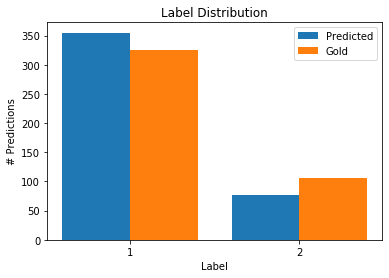

In [274]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)

plot_predictions_histogram(gold_standard,
                           label_model.predict(LF_matrix),
                           title="Label Distribution")